# Bayes for NNs

"Bayesian" means, rather than being some true but unknown value, a parameter

- is viewed as a random variable object 
- so it has a probability distribution 
- which can be combined with data which is informative about the parameter through a likelihood
- to update our knowledge about the distribution of the parameter (from the prior to the posterior) using Bayes theorem


If we approximate the posterior distribution using some other family of distributions with Variational inference, then we are performing approximate Bayesian inference.


## The reparameterization trick

- Section 2.4 of [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) (Kingma/Welling 2013).

This paper is concerned with embedding an observation $x$ into an unknown latent space Z, and takes a Bayesian view of the embedded object $z$; so, z is a "parameter" which can be given a (*a priori*) distribuition, and the target of interest is the updated information about $p(z|x)$.

> Notice, then, that there are a lot of posterior distribiutions $p(z_i|x_i)$, one for every observation $x_i$.

Kingma/Welling propose variational inference to approximate the posterior

\begin{align*}
\overset{prior}{p(z)} \times \overset{likelihood}{f_{\underset{decoder}{\theta(z)}}(x|z)} \propto {} &  \overset{posterior}{p(z|x)} \\
 \approx  {} &  \overset{variational}{\overset{distribution}{q_{\underset{encoder}{\theta(x)}}(z|x)}}
\end{align*}

leading to the variational inference optimization objective

$$\underset{\theta_{dec}, \theta_{enc}}{\max} E_{q_{\theta_{enc}}(z|x)}[\log f_{\theta_{dec}}(x|z)]  - \underbrace{ KL[\, q_{\theta_{enc}}(x|z) \, || \, p(z) \,]}_{E_{q_{\theta_{enc}}(z|x)}\left[\log  \frac{q_{\theta_{enc}}(z|x)}{p(z)}\right] \;\geq\; 0}  $$

Pursuing this objective with gradient descent is thus based on a derivative of an integral, and computing this derivative may require interchanging the order of integration and derivative

$$\frac{d}{d\theta} \int \cdots q_{\theta_{enc}}(z|x) d z \overset{?}{=}  \int \frac{d}{d\theta} \cdots q_{\theta_{enc}}(z|x) d z$$

and the reparameterization trick allows this interchange if a change of variables transformation from independent random variables $\epsilon$, e.g., $z = \mu_x + \sigma_x \epsilon$, is available

$$\text{so } \quad z = g_x(\epsilon) \quad \text{ and } \quad q_{\theta_{enc}}(z|x) = p(\epsilon = g_x^{-1}(z) ) \frac{d g_x^{-1}(z)}{d z}$$

so that

$$\frac{d}{d\theta} \int \cdots q_{\theta_{enc}}(z|x) d z = \frac{d}{d\theta} \int \cdots p(\epsilon) d \epsilon =  \int \frac{d}{d\theta} \cdots p(\epsilon) d \epsilon$$







Comments:

* The KL-divergence in the objective is supposed to be $KL[q_{\theta_{enc}}(z|x) || p(z)]$, as noted in the underbrace.

* Why does the objective use divergence of $q$ with the prior $p(z)$? Are we approximating the posterior using encoder $q$?

**Update**:

A posterior is a balance of the likelihood with the prior. q approximates the posterior by balancing 1. expected log likelihood $E_q(f(x|z))$ 2. the KL-divergence between q and **the prior** $p(z)$



## Bayes by Backprop (BBB)
- Section 3.1 of [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424) (Blundell et al. 2015).

This paper is concerned with taking a Bayesian view of the weights and biases of a neural network archetucture; so, $w$ and $b$ are "parameters" which can be given (*a priori*) distribuitions, and the target of interest is the updated information about $p(w,b|\mathcal{D})$, where $\mathcal{D}$ is the data used to train a neural network.

> Notice that the posterior distribution has many margins $p(w^{(h)}_{jk}|\mathcal{D})$ and $p(b^{(h)}_k|\mathcal{D})$ since there may be many hidden layers $l$ in a neural network, each with weights $w^{(h)}_{jk}$ connecting a node $j$ from a previous layer with a node $k$ in the current layer, and a bias term $b^{(h)}_k$ for each node $k$ in the current layer; and, there may be complex dependency structure within the $w_i$ and $b_i$ random variables in their true joint posterior distribution. 

Blundell et al. examine the (non linear) regression problem parameterized by $\phi \equiv (w,b)$

\begin{align*}
\overset{neural\ network}{\underset{likelihood}{f_{\phi}(y|x)} \; \times}  \underset{prior}{p(\phi|x)} 
\propto {} & \underset{posterior}{p(\phi|x,y)} \\
\approx {} & \overset{variational}{\overset{distribution}{q_\theta(\phi|x,y)}}
\end{align*}

leading to the variational inference optimization objective

$$\underset{\theta}{\max} E_{q_\theta(\phi|x,y)}[\log f_{\phi}(y|x)]  - \underbrace{ KL[\, q_\theta(\phi|x,y) \, || \, p(\phi|x) \,]}_{E_{q_\theta(\phi|x,y)}\left[\log  \frac{q_\theta(\phi|x,y)}{p(\phi|x)}\right] \;\geq\; 0}  $$

and again use the reparameterization trick (of a change of variables transformation of independent random variables) to define

$$\phi = g_\theta(\epsilon)$$

but generalize gradient calculation step using the [total derivative](https://math.stackexchange.com/questions/174270/what-exactly-is-the-difference-between-a-derivative-and-a-total-derivative) (since $\phi$ depends on $\theta$) to propose the (so-called) Bayes by Backprop (BBB) so

\begin{align*}
\frac{\partial}{\partial \theta}E_{q_\theta(\phi|x)}\left[h(\phi, \theta,y,x)\right] = {} & E_{p(\epsilon)}\left[\frac{\partial h(\phi, \theta,y,x)}{\partial \phi}\frac{{\partial \phi}}{\partial \theta} + \frac{{\partial  h(\phi, \theta,y,x)}}{\partial \theta} \frac{\partial \theta}{\partial \theta}\right]\\
= {} & E_{p(\epsilon)}\left[\frac{\partial h(\phi, \theta,y,x)}{\partial \phi}\frac{{\partial \phi}}{\partial \theta} + \frac{{\partial h(\phi, \theta,y,x)}}{\partial \theta}  \right]
\end{align*}




Comments:

* How is the $\theta$ in $q_{\theta}$ same as the $\theta$ in the change of variable $g_{\theta}$? How are they related? 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [20]:
# Set up Bayesian Linear regression using BBB with tensorflow 
# Perhaps this will help?
# https://keras.io/examples/keras_recipes/bayesian_neural_networks/


# load data 
total_size = 4898
train_size = int(total_size * 0.85)
batch_size = 256
dataset = tfds.load(name="wine_quality", as_supervised=True, split="train")
train_set = dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
test_set = dataset.skip(train_size).batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/wine_quality/white/1.0.0.incomplete0GXAQ9/wine_quality-train.tfrecord


  0%|          | 0/4898 [00:00<?, ? examples/s]

Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/white/1.0.0. Subsequent calls will reuse this data.


In [21]:
feature_names = ["fixed acidity", "volatile acidity", "citric acid", 
                "residual sugar", "chlorides", "free sulfur dioxide",
                "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

# Model 1: standard neural network

inputs = [layers.Input(name=f_name, shape=(1,)) for f_name in feature_names]
features = layers.concatenate(inputs)
features = layers.BatchNormalization()(features)

features = layers.Dense(8, activation="sigmoid")(features)
features = layers.Dense(8, activation="sigmoid")(features)
outputs = layers.Dense(1)(features)

nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Model 1 training

lr = 0.001
num_epochs = 100
mse_loss = tf.keras.losses.MeanSquaredError()
nn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
                 loss=mse_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

nn_model.fit(train_set, epochs=num_epochs, validation_data=test_set, verbose=False)

# Model 1 Evaluation

def evaluate_model(model):
  train_loss, train_rmse = model.evaluate(train_set)
  print(f'Training loss: {train_loss:.4}, Training RMSE: {train_rmse:.4}')
  test_loss, test_rmse = model.evaluate(test_set)
  print(f'Test loss: {test_loss:.4}, Test RMSE: {test_rmse:.4}')  

evaluate_model(nn_model)

17/17 [==============================] - 0s 4ms/step - loss: 0.5738 - root_mean_squared_error: 0.7575
Training loss: 0.5738, Training RMSE: 0.7575
3/3 [==============================] - 0s 5ms/step - loss: 0.5697 - root_mean_squared_error: 0.7548
Test loss: 0.5697, Test RMSE: 0.7548


In [22]:
# Model 2: Bayesian neural network (using DenseVariational layer)
# learn weight distributions
# Note that it is the same model for capturing the epistemic uncertainty 
# in the MADE report.

# Define prior of weights

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = tf.keras.Sequential(
      [tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(
          loc=tf.zeros(n), scale_diag=tf.ones(n)
      ))]
      )
  return prior_model

# define posterior of weights (trainable)
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = tf.keras.Sequential(
      [tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
                          # create trainable parameters for MVN with size n
       tfp.layers.MultivariateNormalTriL(n),]
  )
  return posterior_model


# Model 2 BNN 
inputs = [layers.Input(name=f_name, shape=(1,)) for f_name in feature_names]
features = layers.concatenate(inputs)
features = layers.BatchNormalization()(features)

for h in [8, 8]: # hidden units
  features = tfp.layers.DenseVariational(
      units=h, make_prior_fn=prior, make_posterior_fn=posterior,
      kl_weight=1 / train_size, activation="sigmoid"
  )(features)

outputs = layers.Dense(units=1)(features)
bnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# Model 2 training
bnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
                 loss=mse_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

bnn_model.fit(train_set, epochs=num_epochs, validation_data=test_set, verbose=False)

# Model 2 Evaluation
evaluate_model(bnn_model)

17/17 [==============================] - 0s 4ms/step - loss: 0.6599 - root_mean_squared_error: 0.8058
Training loss: 0.6599, Training RMSE: 0.8058
3/3 [==============================] - 0s 6ms/step - loss: 0.6712 - root_mean_squared_error: 0.8131
Test loss: 0.6712, Test RMSE: 0.8131


In [ ]:
# will produce a different output each time for evaluation
evaluate_model(bnn_model)

17/17 [==============================] - 0s 4ms/step - loss: 0.6748 - root_mean_squared_error: 0.8152
Training loss: 0.6748, Training RMSE: 0.8152
3/3 [==============================] - 0s 6ms/step - loss: 0.6570 - root_mean_squared_error: 0.8040
Test loss: 0.657, Test RMSE: 0.804


In [ ]:
# Model 3: Probablistic Bayesian neural network
# the only difference from BNN is to output a probabilistic distribution

inputs = [layers.Input(name=f_name, shape=(1,)) for f_name in feature_names]
features = layers.concatenate(inputs)
features = layers.BatchNormalization()(features)

for h in [8, 8]: # hidden units
  features = tfp.layers.DenseVariational(
      units=h, make_prior_fn=prior, make_posterior_fn=posterior,
      kl_weight=1 / train_size, activation="sigmoid"
  )(features)

# output a distribution 
d_params = layers.Dense(2)(features) # use Dense to learn mean/var
outputs = tfp.layers.IndependentNormal(1)(d_params)

pbnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Model 3 training 

# use negative log-lik as loss function
def neg_loglike(targets, pred_distribution):
  targets = tf.cast(targets, tf.float32) # convert to the same dtype
  return -pred_distribution.log_prob(targets)

pbnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
                 loss=neg_loglike, metrics=[tf.keras.metrics.RootMeanSquaredError()])

pbnn_model.fit(train_set, epochs=num_epochs, validation_data=test_set, verbose=False)

# Model 3 Evaluation
evaluate_model(pbnn_model)

17/17 [==============================] - 0s 5ms/step - loss: 1.2339 - root_mean_squared_error: 1.1684
Training loss: 1.234, Training RMSE: 1.168
3/3 [==============================] - 0s 6ms/step - loss: 1.2178 - root_mean_squared_error: 1.1268
Test loss: 1.218, Test RMSE: 1.127


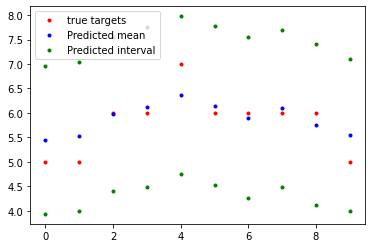

In [ ]:
# Visualize the predicted distribution on a few examples (non-ordered)

n = 10
samples, y = list(test_set.unbatch().shuffle(n).batch(n))[0]

pred_distribution = pbnn_model(samples)
pred_m = pred_distribution.mean().numpy()
pred_std = pred_distribution.stddev().numpy()

# 95% prediction interval 
upper = pred_m + 1.96 * pred_std
lower = pred_m - 1.96 * pred_std

plt.plot(y, "r.", label="true targets")
plt.plot(pred_m, "b.", label="Predicted mean")
plt.plot(upper, "g.", label="Predicted interval")
plt.plot(lower, "g.")
plt.legend()
plt.show()

* We can see the probabilistic BNN model can capture the epistemic uncertainty well
* Most of the true labels are contained in the predicted intervals

## (MC-)Dropout can provide Bayesian approximation
- Kingma, Salimans, and Welling (2015) -- in Sections 3.1-3.3 of [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557) -- propose Bayesian approximation via variational inference of a gaussian dropout neural network. 
  - Gausian Dropout: $\tilde w^{(h)}_{jk} = w^{(h)}_{jk}\times \theta^{(h)}_k \times \xi^{(h)}_k,\; \xi^{(h)}_k\sim N(1,\alpha)$
  - Improper (log uniform) Prior: $p(\log |w^{(h)}_{jk}|) \propto c$
    - This (improper) prior is chosen so no shrinkage (i.e., bias) is induced on the weights; thus, the only form of regularization present is dropout; thus, (ideally) dropout may then be interpreted as characterizing uncertainty rather than simply as a regularization tool.
- Hron, Matthews, and Ghahramani (2017) -- in Section 2 of [Variational Gaussian Dropout is not Bayesian](https://arxiv.org/abs/1711.02989) -- show that the improper prior of Kingma/Salimans/Welling (2015) induces an improper posterior; thus,
  - the posterior that Kingma/Salimans/Welling (2015) attempts to approximate (via variational inference) does not exist and thus the approximation cannot provide a Bayesian approximation interpretation (regardless of whether or not the method itself has good properties as an optimzation objective function).
- Gal and Ghahramani [the same author] (2017) -- in [Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142) and with fuller explanatory details available in [Dropout as a Bayesian Approximation: Appendix](https://arxiv.org/abs/1506.02157) and [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1) -- 
then show that there is a different perspective of neural network dropout which can be characterized as Bayesian approximation; namely,

  $$\underset{\text{point masses}}{\text{Dropout}} \overset{approximates}{\longrightarrow} \underset{\text{via variational inference}}{\text{Sparse Spectrum GP}} \overset{approximates}{\longrightarrow} \text{GP}$$

   where the variational distribuition over $\tilde w^{(h)}_{jk}$ used for sparse spectrum variational inference approximation of a GP is itself approximated by the dropout variational distribuition of a dropout neural network

  $$\tilde w^{(h)}_{jk} \sim p^{(h)}N(m^{(h)}_{jk}, \sigma^2) + (1-p^{(h)})N(0, \sigma^2) \overset{\sigma \rightarrow 0}{\approx}  z^{(h)}_j m^{(h)}_{jk} + (1-z^{(h)}_j), \; z^{(h)}_j \sim bin(p^{(h)})$$

  so while Kingma/Salimans/Welling (2015) focuses interpretation on the variational distributions of each $w^{(h)}_{jk}$, Gal/Ghahramani (2017) focuses interpretation on the entire neural network object itself as a variational distribution approximating a (sparse spectrum) GP.
  
  - Binary Dropout: $\tilde w^{(h)}_{jk} =  w^{(h)}_{jk} \times z^{(h)}_j, \; z_j^{(h)} \sim bin(p^{(h)}),\;$ i.e., input $x_j$ in matrix multiplication $x\tilde W$ disappears
    - $w^{(h)}_{jk}$ are initialized with scale $1/p^{(h)}$ and all $x_j$ are resampled for each forward pass and persist through the following backward pass
    - after training and all $x_j$ are set to $1$ and $w^{(h)}_{jk}$ are scaled by $p^{(h)}$ so the output magnitudes are maintained in th sense that $E[xW]=E[x\tilde W]$
    - other forms of dropout, including Gaussian Dropout, can alternatively be used in this development, but specifics of alternative dropout specifications are not detailed
  - Gaussian Process (GP): a distribution over functions defined by a covariance function that can, e.g., be used as a prior in a Bayesian analysis.
    - The dropout model above approximates a GP; because,
    - A classification or regression objective along with $L_2$ regularization on $w^{(h)}_{jk}$ (and the standard bias parameters) for the dropout model above results in the same objective function as that for sparse spectrum (i.e., sparse weighted basis function) GP approximation.
      - I.e., a GP is a multivariate normal (MVN) distribution with a covariance function, which can be defined with a matrix transformation of an independent MVN, and the matrix transofrmation may be "sparsified" in a spectral (i.e., SVD) manner using a selection prior.
    - GPs are not in general calibrated probability models; meaning, the choice of covariance function dictates the behavior of extrapolation uncertainty.
  - The notations of the key objects of this methodology in this paper are 
    - $\tau$ the precision of the residual of data modeled with a GP
    - $\sigma \rightarrow 0$ which is used to mathematically approximate dropout (two point mass distribution) with a two component mixture of (spikey) normal distributions **viewed as a variational HYPERparameter** (to be tuned/selected)
    - $p^{(h)}_{j}$ the dropout probability **viewed as a variational HYPERparameter** (to be tuned/selected)
    - $m^{(h)}_{jk}$ the location of the nonzero mass component **viewed as a variational parameter** (to be optimized)
    - $l$ (and $l'$ and $K$) which are so-called prior length-scales allowing for informative prior specifications 
    - $p_l(\tilde w^{(h)}_{jk})$ the prior specification
    - $p(\tilde w^{(h)}_{jk}|\mathcal D)$ the true posterior distribution
    - $q_{p_j^{(h)}}(\tilde w^{(h)}_{jk}|\mathcal D)$ the variational distribution approximating the posterior and for which the KL-divergence is evaluated against the prior

      - where for sparse spectral GP approximation and dropout approximation of sparse spectral GP approximation the variational distributions are, respectively

      $$p^{(h)}N(m_{jk}^{(h)}, \sigma^2) + (1-p^{(h)})N(0, \sigma^2) \overset{\sigma \rightarrow 0}{\approx}  z_j^{(h)} m^{(h)}_{jk} + (1-z_j^{(h)}), \; z_j^{(h)} \sim bin(p^{(h)})$$

  




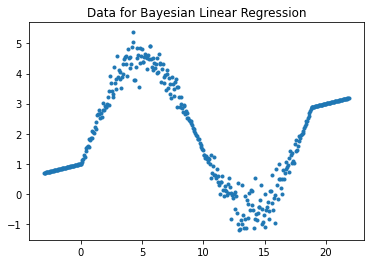

In [6]:
# set up Bayesian Linear regression (with MC-dropout) with tensorflow -- perhaps this will help?
# https://tensorchiefs.github.io/dl_book/
# https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb

def generate_data(n):
  np.random.seed(1)
  x = np.linspace(0, 2*np.pi, n)
  y = 3 * np.sin(x)
  y_noise = np.concatenate((np.zeros(60), 
                            y + np.random.normal(0, 0.15*np.abs(y), n), 
                            np.zeros(60)))
  x_extended = np.concatenate((np.linspace(-3, 0, 60), 
                               np.linspace(0, 6*np.pi, n),
                               np.linspace(6*np.pi, 6*np.pi + 3, 60)))
  y_reg = y_noise + 0.1 * x_extended + 1
  return x_extended, y_reg

x, y = generate_data(300)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

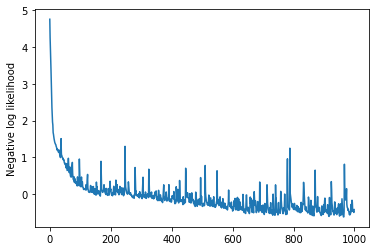

In [12]:
# Model 1: standard neural network

def neg_loglike(target, pred_distribution):
  return -pred_distribution.log_prob(target)

def output_normal(params):
  return tfp.distributions.Normal(
      # mean and variance learned from the previous layer
      loc=params[:,0:1],
      scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2])
  )

inputs = layers.Input(shape=(1,))
features = layers.Dense(50, activation="relu")(inputs)
features = layers.Dense(50, activation="relu")(features)
features = layers.Dense(50, activation="relu")(features)
params = layers.Dense(2)(features)
pred_distribution = tfp.layers.DistributionLambda(output_normal)(params)

model1 = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model1.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)

# fit model 1 
history1 = model1.fit(x, y, epochs=1000, verbose=0, batch_size=32)
plt.plot(history1.history['loss'])
plt.ylabel("Negative log likelihood")
plt.show()


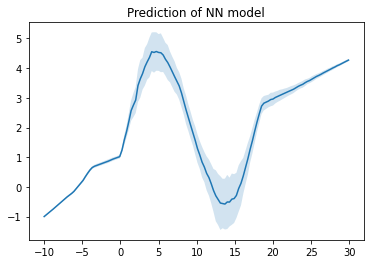

In [47]:
# Model 1 predictions for test
x_test = np.arange(-10, 30, 0.3)

predictions = []
for i in range(200):
  predictions.append(model1.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of NN model")
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


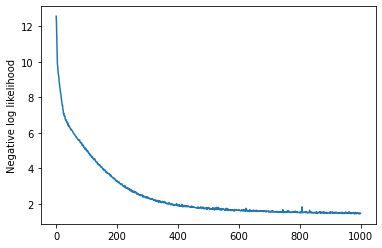

In [36]:
# Model 2: (Bayesian) Variance Inference
def kernel_divergence_fn(q, p, _):
  return tfp.distributions.kl_divergence(q, p) / x.shape[0]
def bias_divergence_fn(q, p, _):
  return tfp.distributions.kl_divergence(q, p) / x.shape[0]

inputs = layers.Input(shape=(1,))
features = tfp.layers.DenseFlipout(20, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                                   bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                                   kernel_divergence_fn=kernel_divergence_fn,
                                   bias_divergence_fn = bias_divergence_fn,
                                   activation = "relu")(inputs)
for i in range(2):
  features = tfp.layers.DenseFlipout(20, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                                   bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                                   kernel_divergence_fn=kernel_divergence_fn,
                                   bias_divergence_fn = bias_divergence_fn,
                                   activation = "relu")(features)
params = tfp.layers.DenseFlipout(2, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                                   bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                                   kernel_divergence_fn=kernel_divergence_fn,
                                   bias_divergence_fn = bias_divergence_fn,
                                   activation = "relu")(features)
pred_distribution = tfp.layers.DistributionLambda(output_normal)(params)

model2 = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model2.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)

history2 = model2.fit(x, y, epochs=1000, verbose=0, batch_size=32)
plt.plot(history2.history['loss'])
plt.ylabel("Negative log likelihood")
plt.show()

Quote from the reference page of tfp.layers.DenseFlipout():

"It uses the Flipout estimator [(Wen et al., 2018)][1], which performs a Monte Carlo approximation of the distribution integrating over the kernel and bias. Flipout uses roughly twice as many floating point operations as the reparameterization estimator but has the advantage of significantly lower variance."

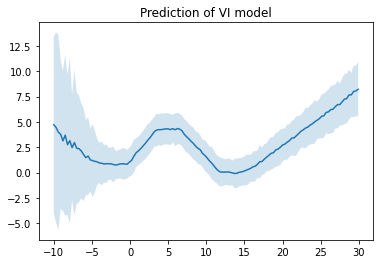

In [52]:
# VI model test
predictions = []
for i in range(200):
  predictions.append(model2.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")
plt.show()

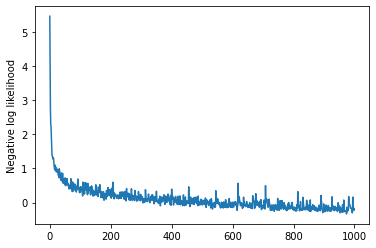

In [51]:
# Model 3 MC Dropout as Bayesian

inputs = layers.Input(shape=(1,))
features = layers.Dense(500, activation="relu")(inputs)
features = layers.Dropout(0.1)(features, training=True)
for i in range(3):
  features = layers.Dense(500, activation="relu")(features)
  features = layers.Dropout(0.1)(features, training=True)
params = layers.Dense(2)(features)
pred_distribution = tfp.layers.DistributionLambda(output_normal)(params)

model_dropout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_dropout.compile(tf.keras.optimizers.Adam(), loss=neg_loglike)
history3 = model_dropout.fit(x, y, epochs=1000, verbose=0, batch_size=32)
plt.plot(history3.history["loss"])
plt.ylabel("Negative log likelihood")
plt.show()


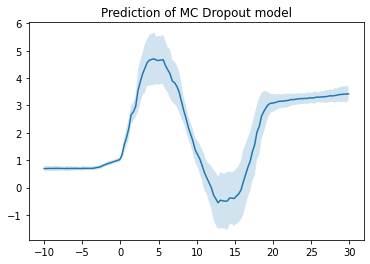

In [54]:
# MC Dropout model test
predictions = []
for i in range(200):
  predictions.append(model_dropout.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of MC Dropout model")
plt.show()

In [ ]:
# Check out Chapter 6 of Gal's PhD Thesis: https://t.co/YXw7UX7I9P?amp=1
# Let's see if our empirical results line up with his theoretical results!


## Other Noise

- Hron, Matthews, and Ghahramani [the same author] (2018) again return to characterize the impact of the distibutional singularity (e.g., point mass) approximation (most clearly presented in [Dropout as a Bayesian Approximation: Appendix](https://arxiv.org/abs/1506.02157)  and [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1)) of Gal/Ghahramani (2017) in Section 4.1 of [Variational Bayesian dropout: pitfalls and fixes](https://arxiv.org/abs/1807.01969); which, inadvertantly, may also provide part of the framework that is helpful in addressing a [criticism raised by Ian Osband](https://mobile.twitter.com/ianosband/status/1014466510885216256?lang=en) regarding posterior mode collapse failure (with related commentary available [here](https://www.reddit.com/r/MachineLearning/comments/8w0v9m/d_ian_osband_dropout_posteriors_give_bad/) and [here](https://www.reddit.com/r/MachineLearning/comments/emt4ke/discussion_research_variational_bayesian/), and some additional notes and illustration available [here](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf)).
  - The "mode collapse failure" issue is that dropout rate $p^{(h)}_j$ may not collapse towards $0$ as data increases even when treated as a variational parameter (and certainly won't if treated as a fixed value).
  - While [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1) shows promising theretical results contradicting the former claim, section 6.4 therein begins examining the various challenges in estimating $p^{(h)}_j$ which do in fact actually exist.
  - The Hron/Matthews/Ghahramani (2018) "pitfalls and fixes" manuscript notes that hyperparameters associated with the prior $p_l(\tilde w^{(h)}_{jk})$, i.e., $l$, may work in favor of the approximation of the (itself approximating) variational distribution, rather than the intended variation distribution (since this itself is being approximated); thus, prior hyperparameters cannot be interpreted as necessarily working in favor of the true posterior; however, this does not address why variational distribution parameters, i.e., $p^{(h)}_j$, are perform problematically as variational parameters.
    - Again, [Chapter 6 of Gal's PhD Thesis](https://t.co/YXw7UX7I9P?amp=1) provides the richest considerations and evaluations regarding this topic.
  - The Hron/Matthews/Ghahramani (2018) "pitfalls and fixes" manuscript manuscript also provides a general framework in which the issues of Kingma/Salimans/Welling (2015) are also addressed.



# In Progress... (aka ignore for now)

- Batch norm paper